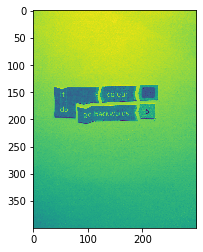

In [843]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 as cv
import pytesseract
import os
from PIL import Image
from scipy.ndimage import label
from scipy.ndimage import binary_opening, binary_closing

# Part 1: resize the image so processing is faster and convert it 
# to grayscale.
A = np.array(Image.open('well-lit.jpg'))
A = np.rot90(A, -1)
A = cv.resize(A, dsize=(300, 400), interpolation=cv.INTER_CUBIC)
A_gray = cv.cvtColor(A, cv.COLOR_BGR2GRAY)
plt.imshow(A_gray)
plt.show()

148.0


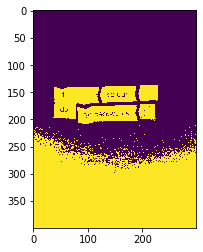

In [844]:
# Part 2: use otsu global thresholding to generate a binary image.
threshold, A_bin = cv.threshold(A_gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
print(threshold)
A_bin = np.invert(A_bin)
plt.imshow(A_bin)
plt.show()

# binarizations works ok but the image is noisy

Low pixel filter 360.0 High pixel filter 36000.0
Initial components: 706
Number of selected components: 5


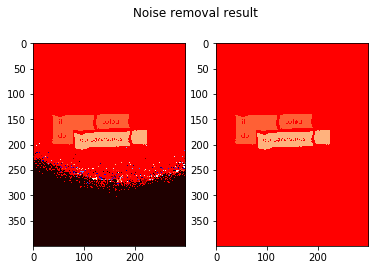

In [845]:
# Part 3: label images features(connected components) and remove any unwanted noise.

# implementing filtering in a function as it will be needed later
# input: binary image
# output: final processed image and raw label() result
def filter_features(binary):
    features_list = label(binary)
    connected_components = features_list[0]
    processed_result = np.copy(connected_components)
    # remove a feature if it covers over 30% of the image or les than 0.03%
    low_filter = .003*np.prod(connected_components.shape)
    high_filter = .3*np.prod(connected_components.shape)
    print('Low pixel filter {} High pixel filter {}'.format(low_filter, high_filter))
    print('Initial components: {}'.format(features_list[1]))
    components = 0
    for feature in range(features_list[1]):
        if((np.count_nonzero(connected_components == feature) < low_filter) or (np.count_nonzero(connected_components == feature) > high_filter)):
            processed_result[connected_components == feature] = 0
            continue
        components += 1
        #print(np.count_nonzero(css == i))
    print('Number of selected components: {}'.format(components))
    return processed_result, connected_components

processed_result, connected_components = filter_features(A_bin)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Noise removal result')
ax1.imshow(connected_components, cmap='flag')
ax2.imshow(processed_result, cmap='flag')
fig.show()
# it is clear that the large shadow and other smaller noise, in terms of pixel size,  is removed

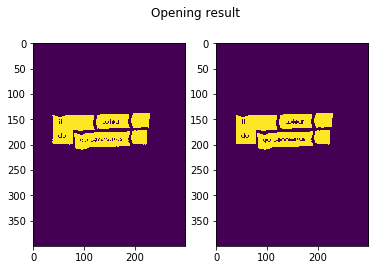

In [846]:
# Part 4: binarize component image to use opening to 
# further suppress the noise.

# usually closing is used after opening but in this case
# closing will reduce the gaps between the code blocks
# so it is ommited.

Bnew_binarized = B_new > 0
x = 3 # window size for opening
B_opened = binary_opening(Bnew_binarized, structure=np.ones((x, x)))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Opening result')
ax1.imshow(Bnew_binarized)
ax2.imshow(B_opened)
fig.show()

Low pixel filter 360.0 High pixel filter 36000.0
Initial components: 12
Number of selected components: 5


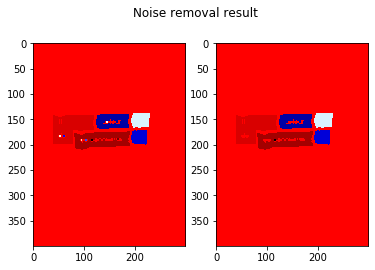

In [847]:
# Part 5: label image's features again to remove letters
# from masking blocks.

result, unprocessed = filter_features(B_opened)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Noise removal result')
ax1.imshow(unprocessed, cmap='flag')
ax2.imshow(result, cmap='flag')
fig.show()

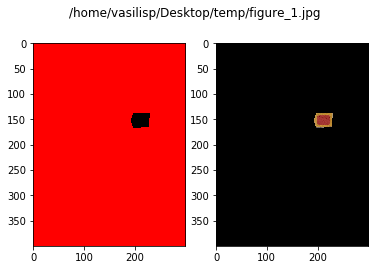

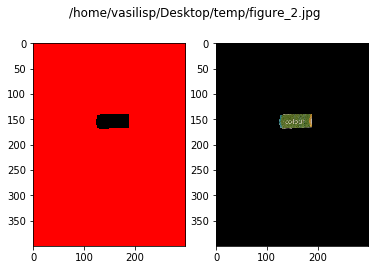

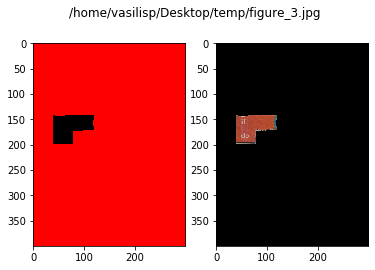

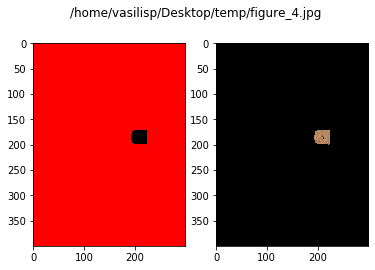

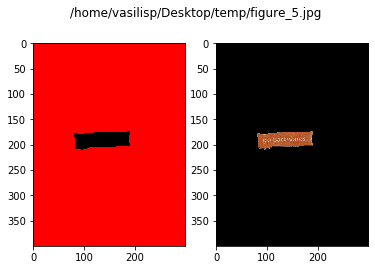

In [851]:
def fill_letters(segmentation, initial_image):
    low_filter = .003*np.prod(segmentation.shape)
    high_filter = .3*np.prod(segmentation.shape)
    window_size = 11
    res = np.copy(segmentation)
    number = 0
    for part in range(np.max(segmentation)):
        A = (segmentation == part)
        # closing to each block
        B = binary_closing(A, structure=np.ones((window_size ,  window_size)))
        if(np.count_nonzero(B) < low_filter or np.count_nonzero(B) > high_filter):
            continue
        number += 1
        input_masked = np.copy(initial_image)
        input_masked[B == False] = 0

        filename = '/home/vasilisp/Desktop/temp/figure_{}.jpg'.format(number)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(filename)
        ax1.imshow(B, cmap='flag')
        ax2.imshow(input_masked, cmap='flag')
        fig.show()   
        figure = Image.fromarray(input_masked)
        figure.save(filename) 
    return(number)

num_figures = fill_letters(result, A)

Tesseract reads

< colour




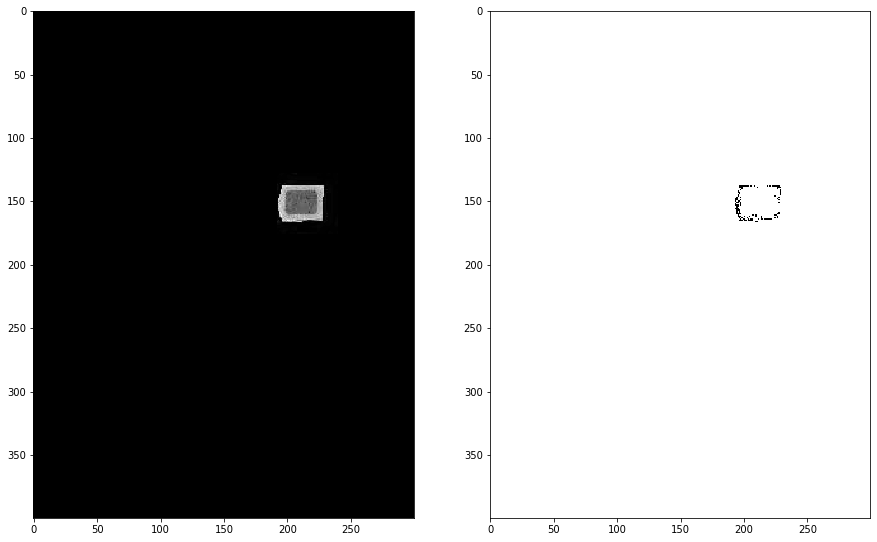

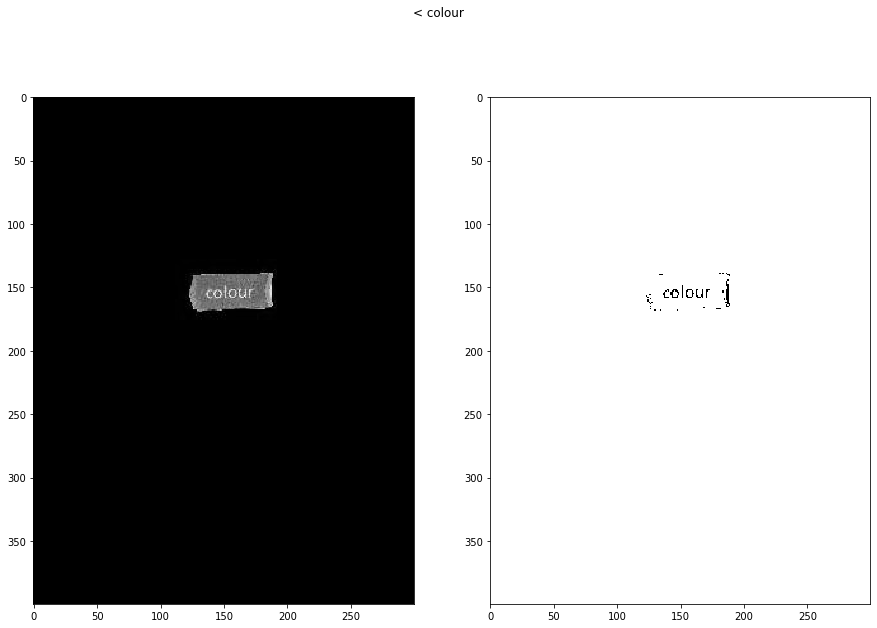

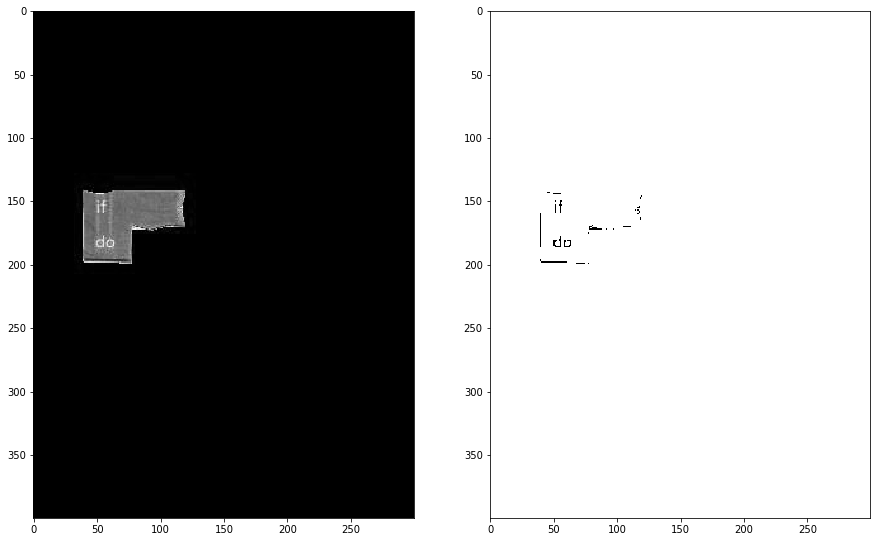

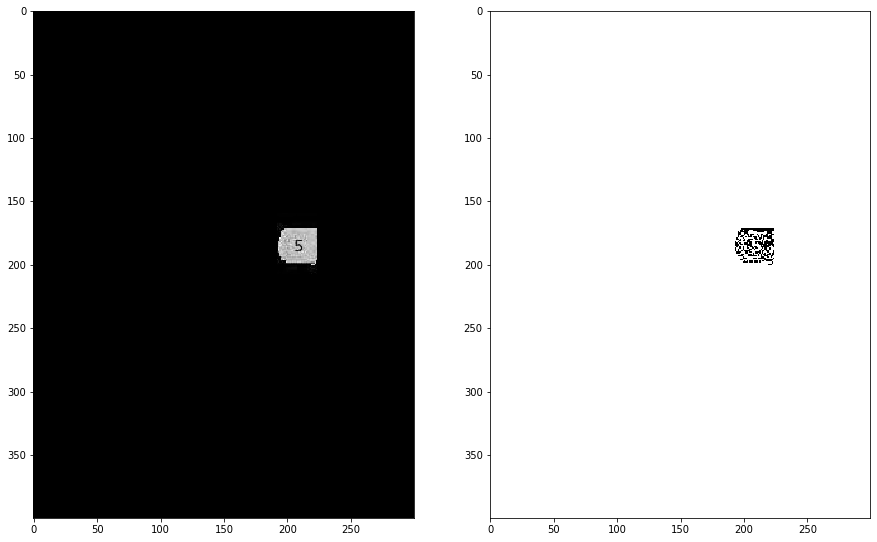

In [864]:
# Part 6 : Testing Tesseract 

temp_directory = '/home/vasilisp/Desktop/temp/'
print('Tesseract reads')
print(num_figures)
for i in range(1, num_figures):
    figure = np.array(Image.open(temp_directory+'figure_'+str(i)+'.jpg'))
    gray = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
    threshold, binary = cv.threshold(gray,127,255,cv.THRESH_BINARY)
    binary = np.invert(binary)
    print(pytesseract.image_to_string(binary))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    fig.suptitle(pytesseract.image_to_string(binary))
    ax1.imshow(gray, cmap='gray')
    ax2.imshow(binary, cmap='gray')
    fig.show()   
#for i in range(1, num_figures):
#    figure = np.array(Image.open(temp_directory+'figure_'+str(i)+'.jpg'))
#    print(pytesseract.image_to_string(figure))